In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h3
import xgboost as xgb

In [4]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df.drop(columns=['commercial;yes'], inplace=True)

train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df.iloc[train_index]
test_h3_l7_df = h3_l7_df.iloc[test_index]

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

# 分离特征和标签
X = spatial_data[:, :-1]  # 特征
Y = spatial_data[:, -1]   # 标签（OHCA）

X_train_reguli = train_spatial_data[:, :-1] 
y_train_reguli = train_spatial_data[:, -1] 
X_test_reguli = test_spatial_data[:, :-1] 
y_test_reguli = test_spatial_data[:, -1] 


In [5]:
import shap
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# 正規化數據 (將特徵縮放到相同範圍，以提高模型的穩定性)
scaler = StandardScaler()
normalized_spatial_data = scaler.fit_transform(h3_spatial_data)

# 設定 SVR 參數
kernel = 'linear'  # 指定核函數
C = 1  # 指定 C 參數
epsilon = 0.05  # 指定 epsilon 參數

# 初始化 SVR 模型
svr = SVR(kernel=kernel, C=C, epsilon=epsilon)

# 訓練模型
svr.fit(X_train_reguli, y_train_reguli)

# 進行預測並評估表現 (轉換回原始尺度)
y_pred_train = svr.predict(X_train_reguli) * ohca_reguli_inverse
y_pred_test = svr.predict(X_test_reguli) * ohca_reguli_inverse


# 計算 MAE (平均絕對誤差) 和 R² (決定係數)
mae_train = mean_absolute_error(y_train_reguli * ohca_reguli_inverse, y_pred_train)
mae_test = mean_absolute_error(y_test_reguli * ohca_reguli_inverse, y_pred_test)

r2_train = r2_score(y_train_reguli * ohca_reguli_inverse, y_pred_train)
r2_test = r2_score(y_test_reguli * ohca_reguli_inverse, y_pred_test)


# 輸出結果
print(f"Kernel: {kernel}")
print(f"C: {C}")
print(f"Epsilon: {epsilon}")
print(f"MAE (Train): {mae_train}")
print(f"MAE (Test): {mae_test}")
print(f"R² (Train): {r2_train}")
print(f"R² (Test): {r2_test}")


Kernel: linear
C: 1
Epsilon: 0.05
MAE (Train): 2.155442200780529
MAE (Test): 5.9113057370852164
R² (Train): 0.9567643526560218
R² (Test): 0.7306680741512512


100%|██████████| 94/94 [02:15<00:00,  1.44s/it]


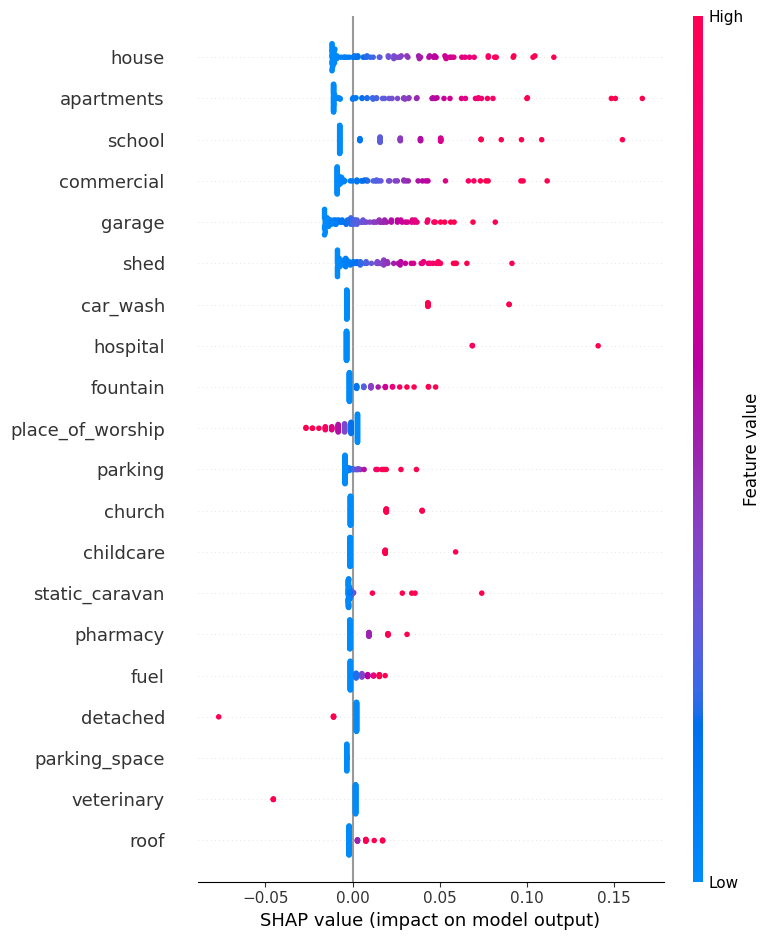

In [8]:
# 使用 SHAP 解釋模型
explainer = shap.KernelExplainer(svr.predict, X_train_reguli)

# 計算 SHAP 值
# shap_values_train = explainer.shap_values(X_train_reguli)
shap_values_test = explainer.shap_values(X_test_reguli)

# Get the shap values from my test data
test_features_df = h3_spatial_data.iloc[:, :-1]
feature_names = test_features_df.columns

shap.summary_plot(shap_values_test, X_test_reguli,feature_names, max_display=20)

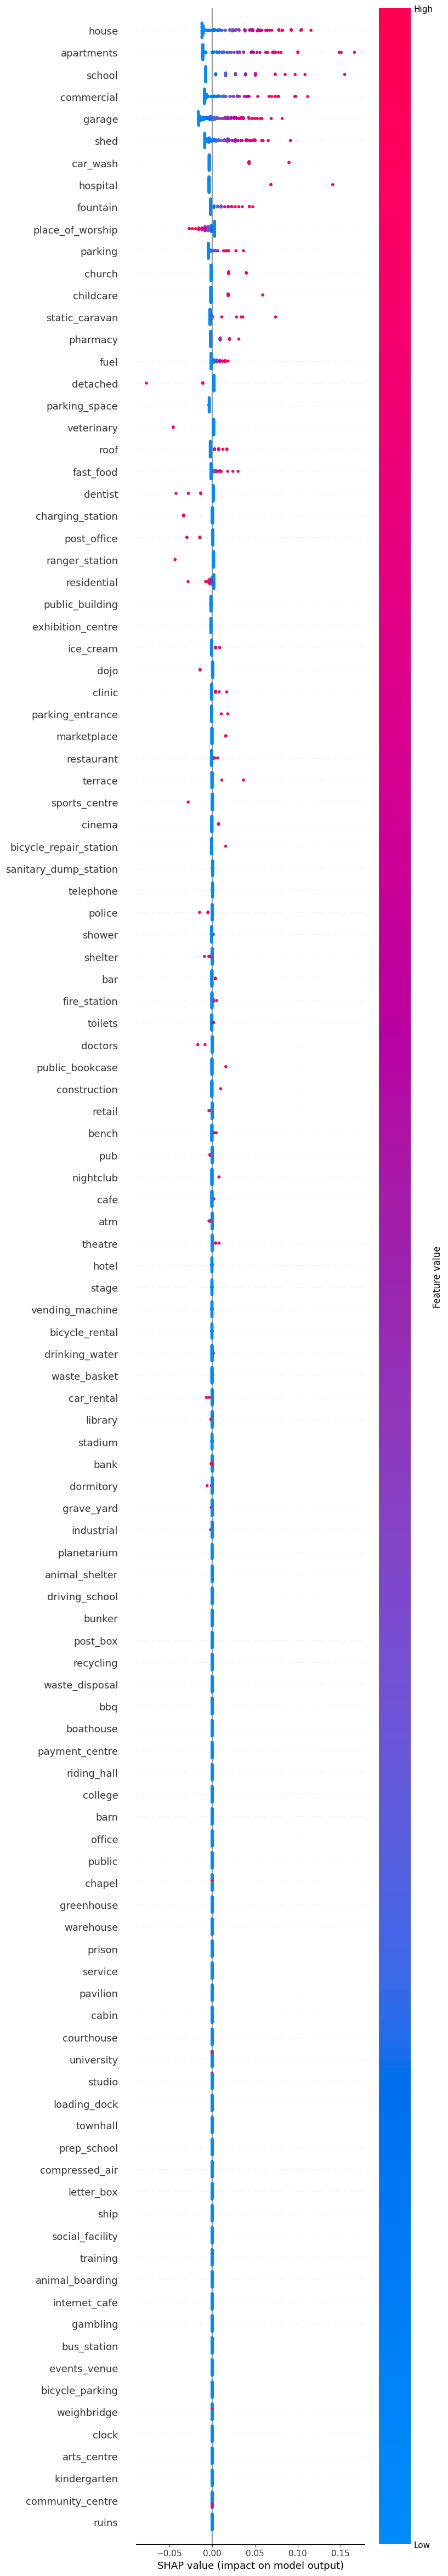

In [9]:
shap.summary_plot(shap_values_test, X_test_reguli,feature_names,max_display=X_test_reguli.shape[1])